# Extra Material: Cutting Stock

The cutting stock problem is familiar to anyone who has cut parts out of stock materials. In the one-dimensional case, the stock materials are available in predetermined lengths and prices. The task is to cut a specific list of parts from the stock materials. The problem is to determine which parts to cut from each piece of stock material to minimize cost. This problem applies broadly to commercial applications, including the allocation of non-physical resources like capital budgeting or resource allocation.

This notebook presents several models and solution algorithms for the cutting stock problem.

In [57]:
# install Pyomo and solvers
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    
SOLVER_MILO = "cbc"
SOLVER_MINLO = "couenne"

## Problem formulation

Consider a set ${S}$ of available stock materials that can be cut to size to produce a set of finished parts. Each stock $s\in S$ is characterized by a length $l^S_s$, a cost $c_s$ per piece, and is available in unlimited quantity. A customer order is received to product a set of finished products $F$. Each finished product $f\in F$ is specified by a required number $d_f$ and length $l^F_f$. 

The **cutting stock problem** is to find a minimum cost solution to fulfill the customer order from the stock materials. The problem is illustrated is by data for an example given in the original paper by Gilmore and Gamory (1961).

**Stocks**

| stocks <br> $s$ | length <br> $l^S_s$ | cost <br> $c_s$ |
| :--: | :--: | :--: |
| A | 5 | 6 |
| B | 6 | 7 |
| C | 9 |10 |

**Finished Parts**

| finished parts <br> $f$ | length <br> $l^F_f$ | demand <br> $d_f$ |
| :--: | :--: | :--: |
| S | 2 | 20 |
| M | 3 | 10 |
| L | 4 | 20 |

This information is represented in Python as nested dictionaries where the names for stocks and finished parts are used as indices.

In [58]:
stocks = {
    'A': {'length': 5, 'cost': 6},
    'B': {'length': 6, 'cost': 7},
    'C': {'length': 9, 'cost': 10},
}

finish = {
    'S': {'length': 2, 'demand': 20},
    'M': {'length': 3, 'demand': 10},
    'L': {'length': 4, 'demand': 20},
}

## Patterns

One approach to solving this problem is to create a list of all finished parts, a list of stocks for each length, and then use a set of binary decision variables to assign each finished product to a particular piece of stock. This approach will work well for a small problems, but the computational complexity scales much too rapidly with the size of the problem to be practical for business applications.

To address the issue of computational complexity, in 1961 Gilmore and Gamory introduced an additional data structure for the problem that is now referred to as "patterns". A pattern is a list of finished parts that can be cut from a particular stock item. 

A pattern $p$ is specified by the stock $s_p$ assigned to the pattern and integers $a_{pf}$ that specify how many finished parts of type $f$ are cut from stock $s_p$. A pattern $p\in P$ is feasible if

$$
\begin{align}
\sum_{f\in F}a_{pf}l^F_f  & \leq   l^S_{s_p}
\end{align}
$$

The function `make_patterns` defined below produces a partial list of feasible patterns for given sets of stocks and finished parts. Each pattern is represented as dictionary that specifies an associated stock item, and a dictionary of cuts that specify the finished parts cut from the stock. The algorithm is simple, it just considers every finished parts and stock items, then reports the number of parts $f$ that can be cut from stock item $s$.

In [59]:
def make_patterns(stocks, finish):
    """
    Generates patterns of feasible cuts from stock lengths to meet specified finish lengths.

    Parameters:
    stocks (dict): A dictionary where keys are stock identifiers and values are dictionaries 
                   with key 'length' representing the length of each stock.

    finish (dict): A dictionary where keys are finish identifiers and values are dictionaries
                   with key 'length' representing the required finish lengths.

    Returns:
    patterns (list): A list of dictionaries, where each dictionary represents a pattern of cuts. 
                   Each pattern dictionary contains 'stock' (the stock identifier) and 'cuts' 
                   (a dictionary where keys are finish identifiers and the value is the number 
                   of cuts from the stock for each finish).
    """
    
    patterns = []
    for f in finish:
        feasible = False
        for s in stocks:
            
            # max number of f that fit on s
            num_cuts = int(stocks[s]['length']/finish[f]['length'])
            
            # make pattern and add to list of patterns
            if num_cuts > 0:
                feasible = True
                cuts_dict = {key: 0 for key in finish.keys()}
                cuts_dict[f] = num_cuts
                patterns.append({'stock': s, 'cuts': cuts_dict})
                    
        if not feasible:
            print(f"No feasible pattern was found for {f}")
            return []
        
    return patterns

patterns = make_patterns(stocks, finish)
display(patterns)

[{'stock': 'A', 'cuts': {'S': 2, 'M': 0, 'L': 0}},
 {'stock': 'B', 'cuts': {'S': 3, 'M': 0, 'L': 0}},
 {'stock': 'C', 'cuts': {'S': 4, 'M': 0, 'L': 0}},
 {'stock': 'A', 'cuts': {'S': 0, 'M': 1, 'L': 0}},
 {'stock': 'B', 'cuts': {'S': 0, 'M': 2, 'L': 0}},
 {'stock': 'C', 'cuts': {'S': 0, 'M': 3, 'L': 0}},
 {'stock': 'A', 'cuts': {'S': 0, 'M': 0, 'L': 1}},
 {'stock': 'B', 'cuts': {'S': 0, 'M': 0, 'L': 1}},
 {'stock': 'C', 'cuts': {'S': 0, 'M': 0, 'L': 2}}]

The function `plot_patterns`, defined below, displays a graphical depiction of the list of patterns. 

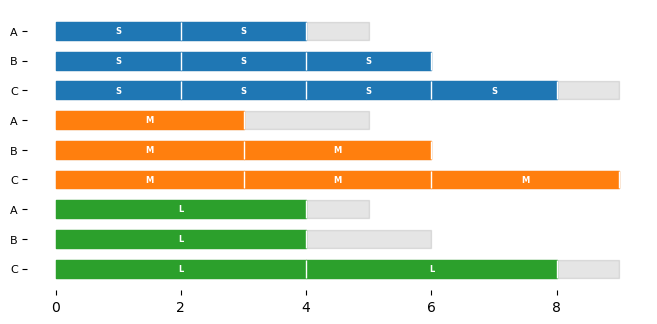

In [60]:
import matplotlib.pyplot as plt

def plot_patterns(stocks, finish, patterns):
    
    # set up figure parameters
    lw = 0.6
    cmap = plt.get_cmap("tab10")
    colors = {f: cmap(k % 10) for k, f in enumerate(finish.keys())}
    fig, ax = plt.subplots(1, 1, figsize=(8, 0.05 + 0.4*len(patterns)))
    
    for k, pattern in enumerate(patterns):
        
        # get stock key/name
        s = pattern['stock']
        
        # plot stock as a grey background
        y_lo = (-k - lw/2, -k - lw/2)
        y_hi = (-k + lw/2, -k + lw/2)
        ax.fill_between((0, stocks[s]['length']), y_lo, y_hi, color="k", alpha=0.1)
        
        # overlay finished parts
        xa = 0
        for f, n  in pattern['cuts'].items():
            for j in range(n):
                xb = xa + finish[f]['length']
                ax.fill_between((xa, xb), y_lo, y_hi, alpha=1.0, color=colors[f])
                ax.plot((xb, xb), (y_lo[0], y_hi[0]), 'w', lw=1, solid_capstyle="butt")
                ax.text((xa + xb)/2, -k, f, ha="center", va="center", fontsize=6, color="w", weight="bold")
                xa = xb
        
    # clean up axes
    ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    ax.set_yticks(range(0, -len(patterns), -1), [pattern['stock'] for pattern in patterns], fontsize=8)
    
    return ax

ax = plot_patterns(stocks, finish, patterns)


## Optimal cutting using known patterns

Given a list of patterns, the optimization problem is to compute how many copies of each pattern should be cut to meet the demand for finished parts at minimum cost. 

Let the index $s_p$ denote the stock specified by pattern $p$, and let $x_{s_p}$ denote the number pieces of stock $s_p$ is used. For a given list of patterns, the minimum cost optimization problem is a mixed integer linear optimization (MILO) subject to meeting demand constraints for each finished item.

$$
\begin{align}
\min\quad & \sum_{p\in P} c_{s_p} x_{s_p} \\
\text{s.t.}\quad
& \sum_{p\in P}a_{pf} x_{s_p} \geq d_f && \forall f\in F\\
& x_{s_p}  \in \mathbb{Z}_+ && \forall p\in P\\
\end{align}
$$

The following cell is a Pyomo implementation of this optimization model.

In [61]:
import pyomo.environ as pyo

# Given dictionaries of stocks and finished parts, and a list of patterns, 
# find minimum choice of patterns to cut

def cut_patterns(stocks, finish, patterns):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, len(patterns)-1)
    
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeIntegers)

    @m.Objective(sense=pyo.minimize)
    def cost(m):
        s = {p: patterns[p]['stock'] for p in m.P}
        c = {p:  stocks[s[p]]['cost'] for p in m.P}
        return sum(c[p] * m.x[p] for p in m.P)

    @m.Constraint(m.F)
    def demand(m, f):
        a = {p: patterns[p]['cuts'][f] for p in m.P}
        return sum(a[p] * m.x[p] for p in m.P) >= finish[f]['demand']
    
    solver = pyo.SolverFactory(SOLVER_MILO)
    solver.solve(m)

    return [m.x[p]() for p in m.P], m.cost()

x, cost = cut_patterns(stocks, finish, patterns)

The following function `plot_nonzero_patterns` is wrapper for `plot_patterns` that removes unused patterns from graphic, shows the number of times each pattern is used, and adds cost to the title.

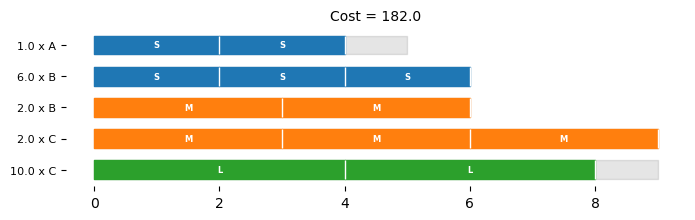

In [62]:
def plot_nonzero_patterns(stocks, finish, patterns, x, cost):
    k = [j for j, _ in enumerate(x) if _ > 0]
    ax = plot_patterns(stocks, finish, [patterns[j] for j in k])
    ticks = [f"{x[k]} x {pattern['stock']}" for k, pattern in enumerate(patterns) if x[k] > 0]
    ax.set_yticks(range(0, -len(k), -1), ticks, fontsize=8)
    ax.set_title(f"Cost = {round(cost,2)}", fontsize=10)
    return ax
    
ax = plot_nonzero_patterns(stocks, finish, patterns, x, cost)

## Cutting Stock Problem: Bilinear reformulation

The `cut_patterns` model requires a known list of cutting patterns. This works well if the patterns comprising an optimal solution to the problem are known. But since they are not initially known, an optimization model is needed that simultaneously solves for an optimal patterns and the cutting list.

Let binary variable $b_{sp}\in\mathbb{Z}_2$ denote the assignment of stock $s$ to pattern $p$, and let $P = 0, 1, \ldots, N_p-1$ index a list of patterns. For sufficiently large $N_p$, an optimal solution to the stock cutting problem is given by the model

$$
\begin{align}
\min\quad & \sum_{s\in S} \sum_{p\in P} c_{s} b_{sp} x_{p} \\
\text{s.t.}\quad
& \sum_{s\in S}b_{sp} =  1 && \forall p\in P \\
& \sum_{f\in F}a_{fp}l^F_f  \leq \sum_{s\in S} b_{sp} l^S_s && \forall p\in P \\
& \sum_{p\in P}a_{fp} x_{p} \geq d_f && \forall f\in F\\
& a_{fp}, x_p  \in \mathbb{Z}_+ && \forall f\in F,  \forall p\in P \\
& b_{sp} \in \mathbb{Z}_2 && \forall s\in S,  \forall p\in P \\
\end{align}
$$

Since there is no ordering of the patterns, without loss of generality an additional constraint can be added to reduce the symmetries present in the problem.

$$
\begin{align}
& x_{p-1} \geq x_{p} && \forall p\in P, p > 0
\end{align}
$$

This is a challenging optimization problem with a cost objective that is bilinear with respect to the the decision variables $b_{sp}$ and $x_p$, and a set of constraints for the demand of finished parts that are bilinear in the decision variables $a_{fp}$ and $x_p$. Because the constraints are a lower bound on a positive sum of bilinear terms, a simple substitution to create rotated quadratic cones fails to produce a convex program.

The following model is a direct translation of the bilinear optimization model into Pyomo. A solution is attempted using a mixed-integer nonlinear optimization (MINLO) solver.

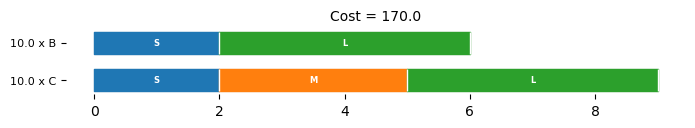

In [63]:
import pyomo.environ as pyo

def bilinear_cut_stock(stocks, finish, Np=len(finish)):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, Np-1)
    
    # sum of all finished parts
    f_total_demand = max([finish[f]['demand'] for f in m.F])
    
    # define a with bounded values
    def a_bounds(m, f, p):
        return (0, max([int(stocks[s]['length']/finish[f]['length']) for s in m.S]))
    m.a = pyo.Var(m.F, m.P, domain=pyo.NonNegativeIntegers, bounds=a_bounds)
    m.b = pyo.Var(m.S, m.P, domain=pyo.Binary)
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeIntegers, bounds=(0, f_total_demand))
    
    # minimize cost
    @m.Objective(sense=pyo.minimize)
    def cost(m):
        c = {s:  stocks[s]['cost'] for s in m.S}
        return sum(c[s]* m.b[s, p] * m.x[p] for s in m.S for p in m.P)

    # assign one stock to each pattern
    @m.Constraint(m.P)
    def assign_each_stock_to_pattern(m, p):
        return sum(m.b[s, p] for s in m.S) == 1

    # pattern feasibility
    @m.Constraint(m.P)
    def feasible_pattern(m, p):
        return sum(m.a[f, p] * finish[f]['length'] for f in m.F) <= sum(m.b[s, p] * stocks[s]['length'] for s in m.S)

    # demand constraints
    @m.Constraint(m.F)
    def demand(m, f):
        return sum(m.a[f, p] * m.x[p] for p in m.P) >= finish[f]['demand']
    
    # order the patterns to reduce symmetries
    @m.Constraint(m.P)
    def order(m, p):
        if p == 0:
            return pyo.Constraint.Skip
        return m.x[p] >= m.x[p-1]
    
    # upper bound on sum of all patterns
    @m.Constraint()
    def max_patterns(m):
        return sum(m.x[p] for p in m.P) <= f_total_demand

    pyo.SolverFactory(SOLVER_MINLO).solve(m)
    
    cost = m.cost()
    x = [m.x[p]() for p in m.P]
    patterns = []
    for p in m.P:
        a = {f: round(m.a[f, p]()) for f in m.F}
        patterns.append({'stock': [s for s in m.S if m.b[s, p]() > 0][0], 'cuts': a})        
    
    return patterns, x, cost


patterns, x, cost = bilinear_cut_stock(stocks, finish, 2)
plot_nonzero_patterns(stocks, finish, patterns, x, cost);

## Pattern Generation: Bilinear Model

From limited testing, the bilinear model for the cutting stock problem appears to work well for small data sets, but does not scale well for larger problem instances, at least for the solvers included in the testing. This shouldn't be surprising given the non-convex nature of the problem, the exclusive use of integer and binary decision variables, and a high degree of symmetry in the model equations.

So rather than attempt to solve the full problem all at once, the following model assumes an initial list of patterns has been determined, perhaps using the `make_patterns` function defined above, then attempts to generate one more pattern that further reduces the objective function. The result remains a non-convex, bilinear optimization problem, but with fewer binary decision variables and at most one bilinear term in the objective and constraints.

$$
\begin{align}
\min\quad & \sum_{p\in P} c_{s_p} x_{s_p} + x' \sum_{s\in S} b_s c_s\\
\text{s.t.}\quad
& \sum_{s\in S}b'_{s} =  1  \\
& \sum_{f\in F}a'_{f}l^F_f  \leq \sum_{s\in S} b'_{s} l^S_s  \\
& \sum_{p\in P}a_{fp} x_{s_p}  + a'_f x'\geq d_f && \forall f\in F\\
& a'_{f}, x_p  \in \mathbb{Z}_+ && \forall f\in F,  \forall p\in P \\
& b'_{s} \in \mathbb{Z}_2 && \forall s\in S \\
\end{align}
$$

The function `generate_pattern_bilinear` is a direct Pyomo implementation that uses a MINLO solver to create one additional feasible pattern that could be added to the list of known patterns.

In [64]:
def generate_pattern_bilinear(stocks, finish, patterns):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, len(patterns)-1)
    
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeIntegers)
    m.xp = pyo.Var(domain=pyo.NonNegativeReals)
    
    def a_bounds(m, f):
        return (0, max([int(stocks[s]['length']/finish[f]['length']) for s in m.S]))
    m.ap = pyo.Var(m.F, domain=pyo.NonNegativeIntegers, bounds=a_bounds)
    m.bp = pyo.Var(m.S, domain=pyo.Binary)

    @m.Objective(sense=pyo.minimize)
    def cost(m):
        s = {p: patterns[p]['stock'] for p in m.P}
        c = {p:  stocks[s[p]]['cost'] for p in m.P}
        return sum(c[p] * m.x[p] for p in m.P) + m.xp * sum(m.bp[s] * stocks[s]['cost'] for s in m.S)
    
    @m.Constraint()
    def sum_to_one(m):
        return sum(m.bp[s] for s in m.S) == 1
    
    @m.Constraint()
    def add_pattern(m):
        return sum(m.ap[f] * finish[f]['length'] for f in m.F) <= sum(m.bp[s] * stocks[s]['length'] for s in m.S)

    @m.Constraint(m.F)
    def demand(m, f):
        return sum(patterns[p]['cuts'][f] * m.x[p] for p in m.P) + m.ap[f] * m.xp >= finish[f]['demand']
    
    solver = pyo.SolverFactory(SOLVER_MINLO)
    solver.solve(m)
    
    new_pattern = {'stock': [s for s in m.S if m.bp[s]() > 0.5][0], 
                   'cuts': {f: round(m.ap[f]()) for f in m.F}}
    
    return new_pattern

In [65]:
stocks = {
    'A': {'length': 5, 'cost': 6},
    'B': {'length': 6, 'cost': 7},
    'C': {'length': 9, 'cost': 10},
}

finish = {
    'S': {'length': 2, 'demand': 20},
    'M': {'length': 3, 'demand': 10},
    'L': {'length': 4, 'demand': 20},
}

patterns = make_patterns(stocks, finish)
generate_pattern_bilinear(stocks, finish, patterns)

{'stock': 'B', 'cuts': {'S': 1, 'M': 0, 'L': 1}}

## Pattern Generation: Linear Dual

A common approach to pattern generation for stock cutting begins by relaxing the MILO optimization problem with known patterns. The integer variables $x_{s_p}$ are relaxed to non-negative reals.

$$
\begin{align}
\min\quad & \sum_{p\in P} c_{s_p} x_{s_p} \\
\text{s.t.}\quad
& \sum_{p\in P}a_{pf} x_{s_p} \geq d_f && \forall f\in F\\
& x_{s_p}  \in \mathbb{R}_+ && \forall p\in P\\
\end{align}
$$

Let $\pi_f \geq 0$ be the dual variables associated with the demand constraints. A large positive value $\pi_f$ suggests a high value for including finished part $f$ in a new pattern. This motivates a set of dual optimization problems where the objective is to construct a new patterns that maximizes the the marginal value of each stock $s\in S$.

$$
\begin{align}
V_s = \max\quad & \left(\sum_{f\in F} \pi_{f} a'_{sf}\right) - c_s \\
\text{s.t.}\quad
& \sum_{f\in F}l^F_f a'_{sf} \leq l^S_s && \\
& a'_{sf}  \in \mathbb{Z}_+ && \forall f\in F\\
\end{align}
$$

The pattern demonstrating the largest return $V_s$ is returned as a candidate to add the list of patterns.

In [71]:
import pyomo.environ as pyo

def generate_pattern_dual(stocks, finish, patterns):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, len(patterns)-1)
    
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.minimize)
    def cost(m):
        s = {p: patterns[p]['stock'] for p in m.P}
        c = {p: stocks[s[p]]['cost'] for p in m.P}
        return sum(c[p] * m.x[p] for p in m.P)

    @m.Constraint(m.F)
    def demand(m, f):
        a = {p: patterns[p]['cuts'][f] for p in m.P}
        return sum(a[p] * m.x[p] for p in m.P) >= finish[f]['demand']
    
    # solve and get duals
    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    solver = pyo.SolverFactory('cbc')
    solver.solve(m)
    
    # solve for reduced cost for each stock
    @m.Block(m.S)
    def subprob(b, s):
        m = b.model()
        b.a = pyo.Var(m.F, domain=pyo.NonNegativeIntegers)
        
        @b.Objective(sense=pyo.maximize)
        def marginal_value(b):
            return  sum(b.a[f] * m.dual[m.demand[f]] for f in m.F)
        
        @b.Constraint()
        def stock_length(b):
            return sum(b.a[f] * finish[f]['length'] for f in m.F) <= stocks[s]['length']
    
        pyo.SolverFactory(SOLVER_MILO).solve(b)
        
        return b
        
    reduced_value = [m.subprob[s].marginal_value() - stocks[s]['cost']  for s in m.S]
    s = list(m.S)[reduced_value.index(max(reduced_value))]

    return {'stock': s, 'cuts': {f: round(m.subprob[s].a[f]()) for f in m.F}}

In [69]:
stocks = {
    'A': {'length': 5, 'cost': 6},
    'B': {'length': 6, 'cost': 7},
    'C': {'length': 9, 'cost': 10},
}

finish = {
    'S': {'length': 2, 'demand': 20},
    'M': {'length': 3, 'demand': 10},
    'L': {'length': 4, 'demand': 20},
}

patterns = make_patterns(stocks, finish)
generate_pattern_dual(stocks, finish, patterns)

{'stock': 'C', 'cuts': {'S': 1, 'M': 1, 'L': 1}}

The following cell compares the time required to generatuses a somewhat larger data set to determine the time required to produce one pattern. Note this test is 

In [70]:
stocks = {
    'log': {'length': 100, 'cost': 1},
}

finish = {
    1:  {'length': 75.0, 'demand': 38},
    2:  {'length': 75.0, 'demand': 44},
    3:  {'length': 75.0, 'demand': 30},
    4:  {'length': 75.0, 'demand': 41},
    5:  {'length': 75.0, 'demand': 36},
    6:  {'length': 53.8, 'demand': 33},
    7:  {'length': 53.0, 'demand': 36},
    8:  {'length': 51.0, 'demand': 41},
    9:  {'length': 50.2, 'demand': 35},
    10: {'length': 32.2, 'demand': 37},
    11: {'length': 30.8, 'demand': 44},
    12: {'length': 29.8, 'demand': 49},
    13: {'length': 20.1, 'demand': 37},
    14: {'length': 16.2, 'demand': 36},
    15: {'length': 14.5, 'demand': 42},
    16: {'length': 11.0, 'demand': 33},
    17: {'length':  8.6, 'demand': 47},
    18: {'length':  8.2, 'demand': 35},
    19: {'length':  6.6, 'demand': 49},
    20: {'length':  5.1, 'demand': 42},
}

patterns = make_patterns(stocks, finish)

print("Testing generate_patterns_bilinear: ", end="")
%timeit generate_pattern_bilinear(stocks, finish, patterns)

print("Testing generate_patterns_dual: ", end="")
%timeit generate_pattern_dual(stocks, finish, patterns)


Testing generate_patterns_bilinear: 1.46 s ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Testing generate_patterns_dual: 155 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## A Solution Algorithm

The following cell implements an algorithm to solve the cutting stock problem. The algorithm starts with 

... Finished



<Axes: title={'center': 'Cost = 170.0'}>

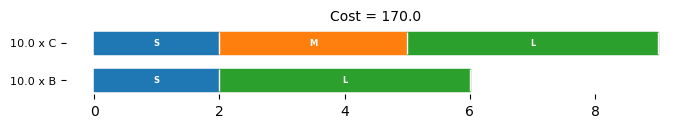

In [36]:
def cut_stock(stocks, finish, pattern_generator, max_iter=50):
    
    patterns = make_patterns(stocks, finish)
    
    for k in range(max_iter):
        print(".", end="")
        new_pattern = pattern_generator(stocks, finish, patterns)
        if new_pattern in patterns:
            break
        patterns.append(new_pattern)
        
    else:
        print(f"\nDidn't Converge in {max_iter} iterations")
        return
    
    # return non-zero patterns
    print(" Finished\n")
    x, cost = cut_patterns(stocks, finish, patterns) 
    k = [j for j, _ in enumerate(x) if _ > 0]
    return [patterns[j] for j in k], [x[j] for j in k], cost
       
patterns, x, cost = cut_stock(stocks, finish, generate_pattern_dual)
plot_nonzero_patterns(stocks, finish, patterns, x, cost)

## Examples

### Example from JuMP documentation for column generation

https://jump.dev/JuMP.jl/stable/tutorials/algorithms/cutting_stock_column_generation/#:~:text=The%20cutting%20stock%20problem%20is,while%20maximizing%20the%20total%20profit.

............ Finished



<Axes: title={'center': 'Cost = 334.0'}>

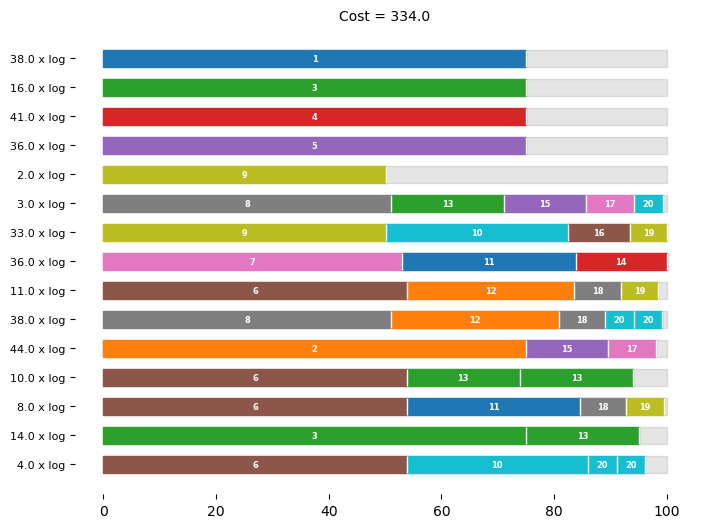

In [38]:
stocks = {
    'log': {'length': 100, 'cost': 1},
}

finish = {
    1:  {'length': 75.0, 'demand': 38},
    2:  {'length': 75.0, 'demand': 44},
    3:  {'length': 75.0, 'demand': 30},
    4:  {'length': 75.0, 'demand': 41},
    5:  {'length': 75.0, 'demand': 36},
    6:  {'length': 53.8, 'demand': 33},
    7:  {'length': 53.0, 'demand': 36},
    8:  {'length': 51.0, 'demand': 41},
    9:  {'length': 50.2, 'demand': 35},
    10: {'length': 32.2, 'demand': 37},
    11: {'length': 30.8, 'demand': 44},
    12: {'length': 29.8, 'demand': 49},
    13: {'length': 20.1, 'demand': 37},
    14: {'length': 16.2, 'demand': 36},
    15: {'length': 14.5, 'demand': 42},
    16: {'length': 11.0, 'demand': 33},
    17: {'length':  8.6, 'demand': 47},
    18: {'length':  8.2, 'demand': 35},
    19: {'length':  6.6, 'demand': 49},
    20: {'length':  5.1, 'demand': 42},
}

patterns, x, cost = cut_stock(stocks, finish, generate_pattern_bilinear)
plot_nonzero_patterns(stocks, finish, patterns, x, cost)

### Example from Wikipedia

https://en.wikipedia.org/wiki/Cutting_stock_problem

The minimum number of rolls is 73.0.

.......................... Finished



<Axes: title={'center': 'Cost = 73.0'}>

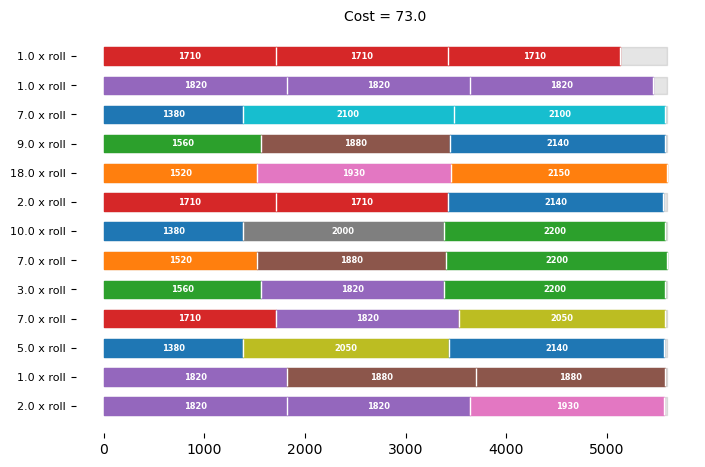

In [13]:
stocks = {
    'roll': {'length': 5600, 'cost': 1},
}

finish = {
    1380: {'length': 1380, 'demand': 22},
    1520: {'length': 1520, 'demand': 25},
    1560: {'length': 1560, 'demand': 12},
    1710: {'length': 1710, 'demand': 14},
    1820: {'length': 1820, 'demand': 18},
    1880: {'length': 1880, 'demand': 18},
    1930: {'length': 1930, 'demand': 20},
    2000: {'length': 2000, 'demand': 10},
    2050: {'length': 2050, 'demand': 12},
    2100: {'length': 2100, 'demand': 14},
    2140: {'length': 2140, 'demand': 16},
    2150: {'length': 2150, 'demand': 18},
    2200: {'length': 2200, 'demand': 20},
}

patterns, x, cost = cut_stock(stocks, finish, generate_pattern_dual)
plot_nonzero_patterns(stocks, finish, patterns, x, cost)

### Woodworking: Problem data from Google sheets

Find a minimum cost order of 2x4 lumber to build the ["One Arm 2x4 Outdoor Sofa" described by Ana White](https://www.ana-white.com/woodworking-projects/one-arm-2x4-outdoor-sofa-sectional-piece).

![](https://www.ana-white.com/sites/default/files/images/diy%202x4%20sectional%20single%20arm%20ana%20white%20dimensions.jpg)
Image source: www.ana-white.com

Data source: https://docs.google.com/spreadsheets/d/1ZX7KJ2kwTGgyqEv_a3LOG0nQSxsc38Ykk53A7vGWAFU/edit#gid=1104632299

In [14]:
import pandas as pd

def read_google_sheet(sheet_id, sheet_name):
    """
    Reads a Google Sheet and returns a pandas DataFrame.

    This function reads a Google Sheet with the specified sheet ID and sheet name,
    and returns a pandas DataFrame with the data. The column names are converted to
    lowercase.

    Args:
        sheet_id (str): The Google Sheet ID.
        sheet_name (str): The name of the sheet to read.

    Returns:
        df (pd.DataFrame): A pandas DataFrame containing the data from the Google Sheet.
    """
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)
    df.columns = map(str.lower, df.columns)
    return df

In [15]:
# Google Sheet ID
sheet_id = "1ZX7KJ2kwTGgyqEv_a3LOG0nQSxsc38Ykk53A7vGWAFU"

# read settings
settings_df = read_google_sheet(sheet_id, "settings")
print("\nSettings")
display(settings_df)

# read parts
finish_df = read_google_sheet(sheet_id, "finish")
print("\nFinish")
display(finish_df)

# read and display stocks
stocks_df = read_google_sheet(sheet_id, "stocks")
#stocks = stocks.drop(["price"], axis=1)
if not "price" in stocks_df.columns:
    stocks["price"] = stocks_df["length"]
print("\nStocks")
display(stocks_df)


Settings


,setting,value
0,kerf,0.125



Finish


,kind,length,quantity,label
0,2x4,70.50,3,70.50
1,2x4,25.50,10,25.50
2,2x4,12.50,1,12.50
3,2x4,72.00,6,72.00
4,2x4,70.75,1,70.75
5,2x4,28.50,1,28.50



Stocks


,kind,length,price
0,2x4,36,1.68
1,2x4,48,1.86
2,2x4,72,2.57
3,2x4,84,2.65
4,2x4,96,2.92
5,2x4,120,3.67
6,2x4,144,4.40
7,2x4,168,5.14
8,2x4,192,6.92
9,2x4,216,8.62


Kind = 2x4
.... Finished



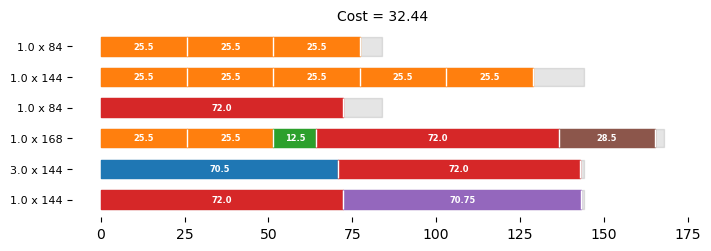

In [17]:
kinds = tuple(set(finish_df['kind']))

kerf = 0.25

for kind in kinds:
    print(f"Kind = {kind}")
    
    finish = dict()
    for i in finish_df.loc[finish_df['kind'] == kind].index:
        finish[finish_df.loc[i, 'label']] = {'length': finish_df.loc[i, 'length'] + kerf,
                                             'demand': finish_df.loc[i, 'quantity']}
        
    stocks = dict()
    for i in stocks_df.loc[stocks_df['kind'] == kind].index:
        stocks[stocks_df.loc[i, 'length']] = {'length': stocks_df.loc[i, 'length'] + 0*kerf,
                                             'cost': stocks_df.loc[i, 'price']}
    
    patterns, x, cost = cut_stock(stocks, finish, generate_pattern_dual)
    plot_nonzero_patterns(stocks, finish, patterns, x, cost)
    

Purchase List

In [18]:
df = pd.DataFrame(patterns)
df['cuts'] = x
df['stock'] = df['stock'].astype(str)
df = df.pivot_table(index='stock', values='cuts', aggfunc='sum')
df.index = df.index.astype(int)
df = df.sort_index()

df

,cuts
stock,
84,2.0
144,5.0
168,1.0


## References

The one dimensional cutting stock problem addressed in this notebook is generally attributed to two classic papers by Gilmore and Gomory. This first paper considers the more general case of stocks available in multiple lengths, while the second paper specializes to the needs of a paper trimming operation.

> Gilmore, P. C., & Gomory, R. E. (1961). A linear programming approach to the cutting-stock problem. Operations research, 9(6), 849-859. [[jstor](https://www.jstor.org/stable/pdf/167051.pdf)]

> Gilmore, P. C., & Gomory, R. E. (1963). A linear programming approach to the cutting stock problem—Part II. Operations research, 11(6), 863-888. [[jstor](https://www.jstor.org/stable/pdf/167827.pdf)]

A useful survey of subsequent development of the cutting stock problem is given by:

> Haessler, R. W., & Sweeney, P. E. (1991). Cutting stock problems and solution procedures. European Journal of Operational Research, 54(2), 141-150. [[pdf](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/29128/0000167.pdf)]

> Delorme, M., Iori, M., & Martello, S. (2016). Bin packing and cutting stock problems: Mathematical models and exact algorithms. European Journal of Operational Research, 255(1), 1-20. [[sciencedirect](https://www.sciencedirect.com/science/article/pii/S0377221716302491)]

The solution proposed by Gilmore and Gamory has been refined over time and now generally referred to as "column generation". A number of tutorial implemenations are available, these are representative:

> * [Mathworks/Matlab: Cutting Stock Problem](https://www.mathworks.com/help/optim/ug/cutting-stock-problem-based.html)
* [AIMMS: Cutting Stock Problem](https://download.aimms.com/aimms/download/manuals/AIMMS3OM_CuttingStock.pdf)
* [SCIP:Bin packing and cutting stock problems](https://scipbook.readthedocs.io/en/latest/bpp.html)
* [PuLP: Implementation](https://github.com/coin-or/pulp/blob/master/examples/CGcolumnwise.py)

More recently, the essential bilinear structure of the problem has been noted, and various convex transformations of the problem have been studied:

> Harjunkoski, I., Westerlund, T., Pörn, R., & Skrifvars, H. (1998). Different transformations for solving non-convex trim-loss problems by MINLP. European Journal of Operational Research, 105(3), 594-603. [[abo.fi](http://users.abo.fi/twesterl/some-selected-papers/49.%20EJOR-IH-TW-RP-HS-1998.pdf)][[sciencedirect](https://www.sciencedirect.com/science/article/pii/S0377221797000660)]

> Harjunkoski, I., Pörn, R., & Westerlund, T. (1999). Exploring the convex transformations for solving non-convex bilinear integer problems. Computers & Chemical Engineering, 23, S471-S474. [[sciencedirect](https://www.sciencedirect.com/science/article/pii/S0098135499801161)